# **Dog Breed Classification **
## Grp 7 : Maalal Ilyas - Aya El Janati


## **Installing and Importing Libraries**




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1



## **Chargement et préparation du dataset**


Chargement de données

In [4]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Images'


1.   On prépare un ImageDataGenerator pour appliquer de l'élargissement de données (data augmentation), ce qui permet de rendre le modèle plus robuste.

2. On génère les images d'entraînement à partir du dossier.

3. Idem pour les données de validation.




In [5]:

IMG_SIZE = 224
BATCH_SIZE = 32

# Générateurs de données avec data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

NUM_CLASSES = len(train_generator.class_indices)
# print(train_generator.class_indices)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


Nombre de classes : 120


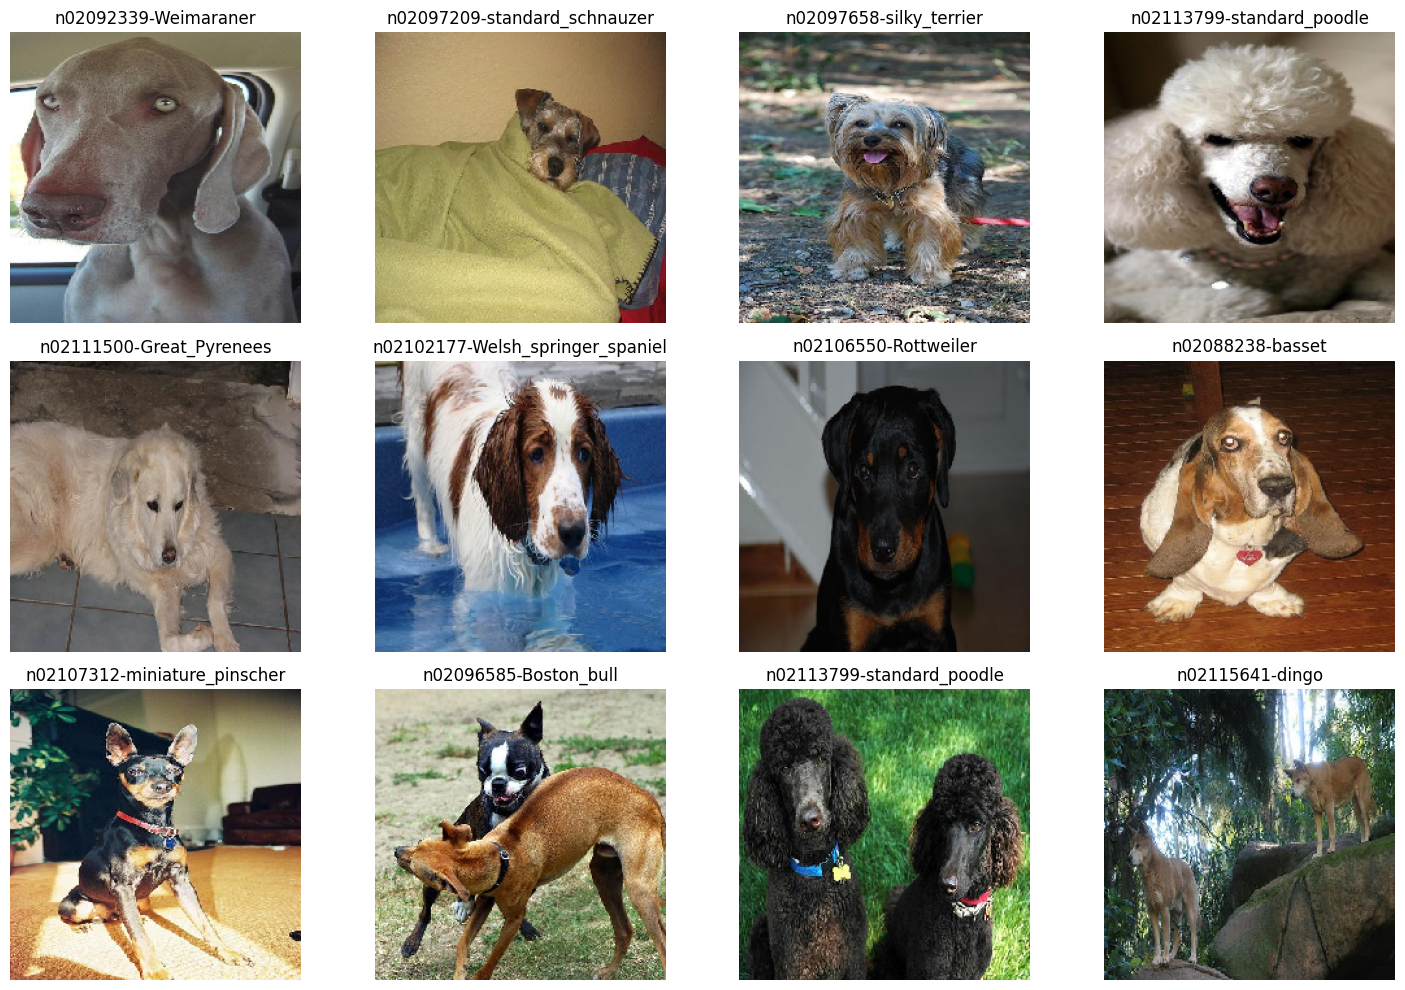

In [14]:
import random
from tensorflow.keras.preprocessing import image

classes = os.listdir(DATA_DIR)
print(f"Nombre de classes : {len(classes)}")

# Affiche quelques images aléatoires
plt.figure(figsize=(15, 10))
for i in range(12):
    class_name = random.choice(classes)
    img_list = os.listdir(os.path.join(DATA_DIR, class_name))
    img_path = os.path.join(DATA_DIR, class_name, random.choice(img_list))

    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

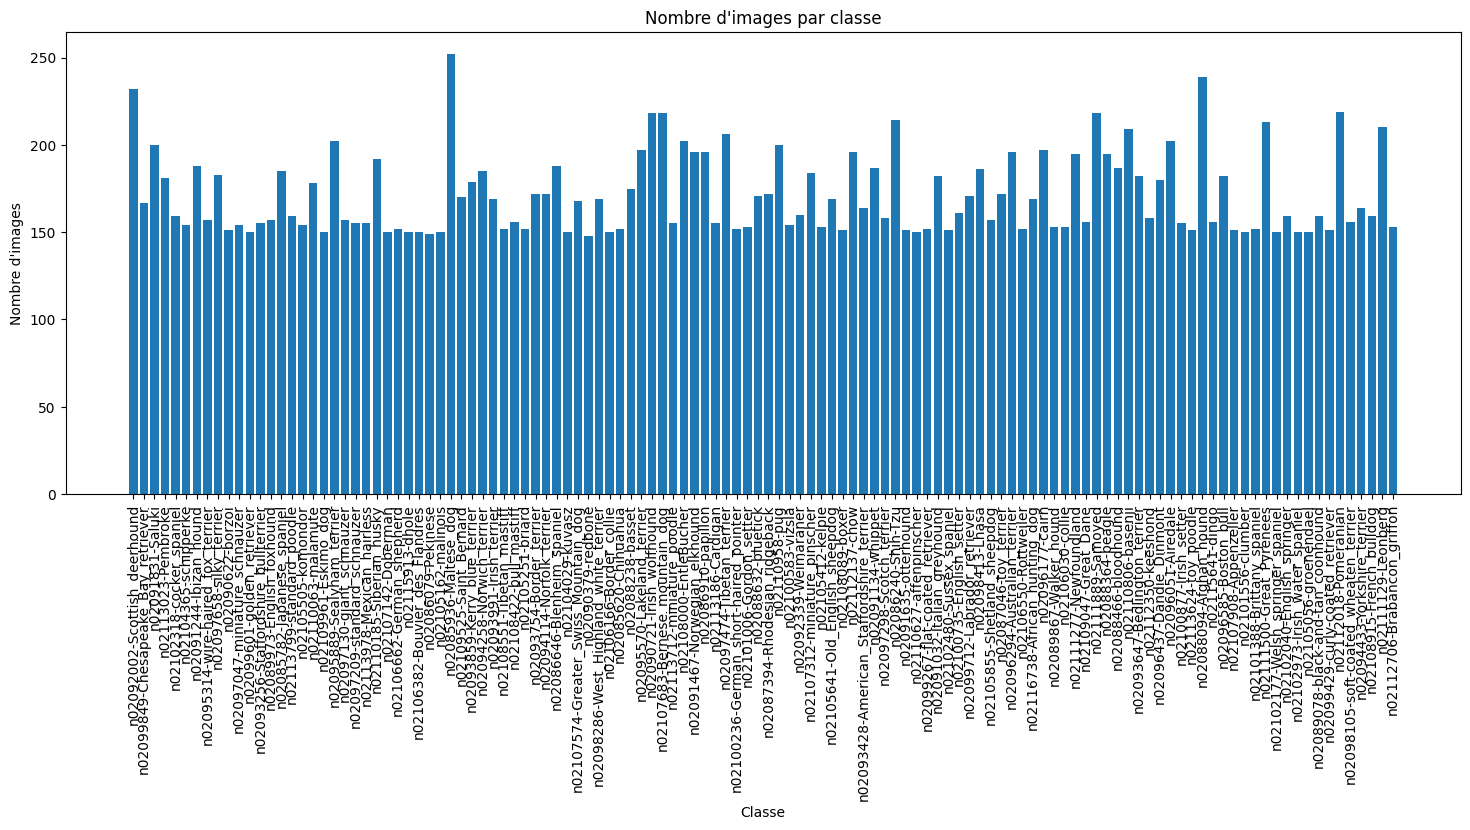

In [16]:
from collections import Counter

# Compter les images par classe
class_counts = {}
for class_name in classes:
    class_folder = os.path.join(DATA_DIR, class_name)
    class_counts[class_name] = len(os.listdir(class_folder))

# Afficher
plt.figure(figsize=(18, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title("Nombre d'images par classe")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.show()

             Width       Height
count   600.000000   600.000000
mean    442.811667   382.676667
std     128.096177   112.682523
min     106.000000   120.000000
25%     369.750000   333.000000
50%     500.000000   375.000000
75%     500.000000   446.000000
max    1616.000000  1529.000000


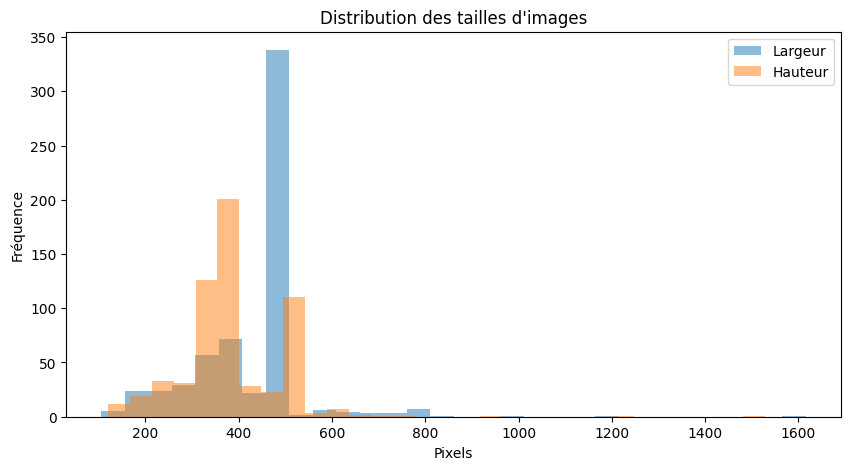

In [18]:
img_shapes = []

for class_name in classes:
    class_folder = os.path.join(DATA_DIR, class_name)
    img_list = os.listdir(class_folder)
    for img_file in random.sample(img_list, min(5, len(img_list))):  # prendre un échantillon
        img_path = os.path.join(class_folder, img_file)
        img = image.load_img(img_path)
        img_shapes.append(img.size)

# Transformation en DataFrame
import pandas as pd
img_shapes_df = pd.DataFrame(img_shapes, columns=["Width", "Height"])

# Affichage
print(img_shapes_df.describe())

# Plot
plt.figure(figsize=(10,5))
plt.hist(img_shapes_df['Width'], bins=30, alpha=0.5, label='Largeur')
plt.hist(img_shapes_df['Height'], bins=30, alpha=0.5, label='Hauteur')
plt.legend()
plt.title("Distribution des tailles d'images")
plt.xlabel("Pixels")
plt.ylabel("Fréquence")
plt.show()


In [19]:
from PIL import Image
corrupted_images = []

for class_name in classes:
    class_folder = os.path.join(DATA_DIR, class_name)
    img_list = os.listdir(class_folder)
    for img_file in img_list:
        img_path = os.path.join(class_folder, img_file)
        try:
            img = Image.open(img_path)
            img.verify()  # Vérifie si le fichier est lisible
        except (IOError, SyntaxError) as e:
            corrupted_images.append(img_path)

print(f"Nombre d'images corrompues : {len(corrupted_images)}")


Nombre d'images corrompues : 0


## **Construction du modèle de base (CNN simple)**

- 3 blocs convolution + max pooling

- Flatten pour passer à des couches denses

- Softmax pour obtenir une prédiction multi-classe.

On compile le modèle avec :

- Adam comme optimiseur.

- Categorical Crossentropy pour un problème de classification multi-classes.

In [ ]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history_cnn = cnn_model.fit(train_generator, validation_data=val_generator, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 5178s 10s/step - accuracy: 0.0089 - loss: 4.8074 - val_accuracy: 0.0113 - val_loss: 4.7816
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 2701s 5s/step - accuracy: 0.0115 - loss: 4.7818 - val_accuracy: 0.0123 - val_loss: 4.7796
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 2736s 5s/step - accuracy: 0.0127 - loss: 4.7808 - val_accuracy: 0.0123 - val_loss: 4.7793
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 2687s 5s/step - accuracy: 0.0116 - loss: 4.7793 - val_accuracy: 0.0123 - val_loss: 4.7791
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 2677s 5s/step - accuracy: 0.0113 - loss: 4.7803 - val_accuracy: 0.0123 - val_loss: 4.7789
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 2656s 5s/step - accuracy: 0.0127 - loss: 4.7810 - val_accuracy: 0.0123 - val_loss: 4.7788
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 2612s 5s/step - accuracy: 0.0138 - loss: 4.7790 - val_accuracy: 0.0123 - val_loss: 4.7791
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 2610s 5s/step - accuracy: 0.0120 - loss: 4.7795 -

## **Transfer Learning avec MobileNetV2**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
REPLICAS:  1
Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 4981s 10s/step - accuracy: 0.3906 - loss: 2.6585 - val_accuracy: 0.6776 - val_loss: 1.1278
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1252s 2s/step - accuracy: 0.7011 - loss: 1.0059 - val_accuracy: 0.6891 - val_loss: 1.0593
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1215s 2s/step - accuracy: 0.7258 - loss: 0.9047 - val_accuracy: 0.7105 - val_loss: 1.0210
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1232s 2s/step - accuracy: 0.7518 - loss: 0.8338 - val_accuracy: 0.7024 - val_loss: 1.0571
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1159s 2s/step - accuracy: 0.7764 - loss: 0.7413 - val_accuracy: 0.7036 - val_loss: 1.0514
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1197s 2s/step - accuracy: 0.7828 - loss: 0.6879 - val_accuracy: 0.7097 - val_loss: 1.0643
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1200s 2s/step - accuracy: 0.7859 - lo


✅ Précision finale MobileNetV2 Transfer Learning : 70.19%


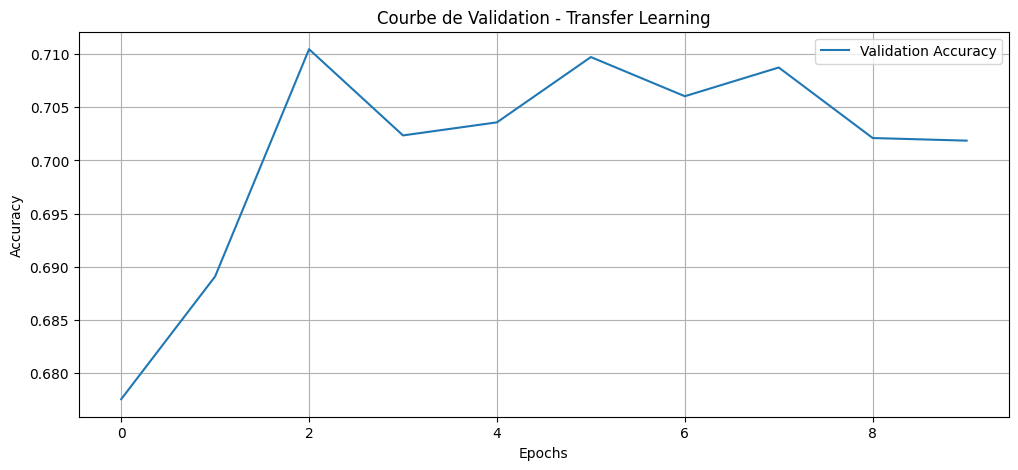

In [ ]:

IMG_SIZE = 224
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

transfer_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(NUM_CLASSES, activation='softmax')
])

transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_transfer = transfer_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

# Sauvegarde du modèle dans Google Drive
transfer_model.save('/content/drive/MyDrive/mobilenet_model.h5')

acc_transfer = history_transfer.history['val_accuracy'][-1]

plt.figure(figsize=(8,6))
plt.plot(history_transfer.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_transfer.history['accuracy'], label='Accuracy')
plt.title('Accuracy durant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()